In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys

sys.path.insert(0, '../')

In [2]:
import imports as im
import functions as fn
from datetime import datetime
import pickle
%matplotlib inline

## Data Preporation

In [3]:
x_data_hc = im.np.load("x_data_hc.npy")
y_data_hc = im.np.load("y_data_hc.npy")

In [4]:
x_data_hc_augmented, y_data_hc_augmented = fn.augment_data(x_data_hc, y_data_hc, augmentation_factor=12000)

In [5]:
x_train_val, x_test_hc, y_train_val, y_test_hc = im.train_test_split(x_data_hc_augmented, y_data_hc_augmented, test_size=0.1, random_state=42, shuffle=True, stratify=y_data_hc_augmented)

In [6]:
x_train_hc, x_val_hc, y_train_hc, y_val_hc = im.train_test_split(x_train_val, y_train_val, test_size=0.1, random_state=42, shuffle=True, stratify=y_train_val)

In [7]:
train_data_hc = im.tf.data.Dataset.from_tensor_slices((x_train_hc, y_train_hc))
val_data_hc = im.tf.data.Dataset.from_tensor_slices((x_val_hc, y_val_hc))
test_data_hc = im.tf.data.Dataset.from_tensor_slices((x_test_hc, y_test_hc))

batch_size = 64

train_data_hc = train_data_hc.batch(batch_size)
val_data_hc = val_data_hc.batch(batch_size)
test_data_hc = test_data_hc.batch(batch_size)

## Multi-Head Attention

In [8]:
# Define input and output shapes
input_shape = x_train_hc.shape[-2:]
# output_shape = y_train_hc.shape[-1]

In [12]:
# Define the number of recurrent units
num_recurrent_units = 64
# Define the number of attention heads
num_attention_heads = 8

inputs = im.Input(shape=input_shape)
recurrent_layer = im.LSTM(num_recurrent_units, return_sequences=True)(inputs)
attention_layer = im.MultiHeadAttention(
    num_heads=num_attention_heads, key_dim=num_recurrent_units
)(inputs, inputs)

attention_output = im.LayerNormalization()(im.keras.layers.concatenate([attention_layer, recurrent_layer])
)
dense_layer = im.TimeDistributed(im.Dense(512, activation='relu'))(attention_output)
dense_layer = im.TimeDistributed(im.Dense(64, activation='relu'))(dense_layer)
dense_layer = im.Flatten()(dense_layer)
dense_layer = im.Dense(1, activation='sigmoid')(dense_layer)

# Define the model
model = im.Model(inputs=inputs, outputs=dense_layer)

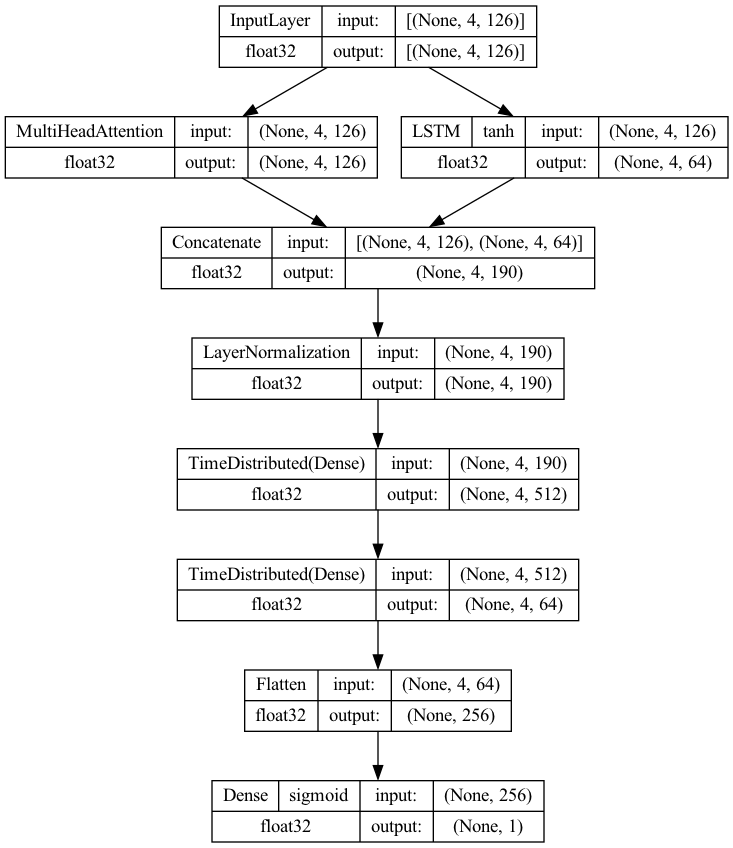

In [13]:
# Print model

model_img_file = '../../images/transformer_model.png'
im.tf.keras.utils.plot_model(model, to_file=model_img_file, 
                            show_shapes=True, 
                            show_layer_activations=True, 
                            show_dtype=True,
                            show_layer_names=False)

In [101]:
# Learning Rate Schedule for Fine Tuning 
def exponential_lr(epoch,
                   start_lr = 0.001, min_lr = 0.00001, max_lr = 0.005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.85):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

In [102]:
# Compile the model
# model.compile(optimizer='adam', loss=fn.binary_focal_loss(), metrics=['accuracy', fn.f1_score, fn.recall, fn.precision])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', fn.f1_score, fn.recall, fn.precision])

In [103]:
epochs = 50

weights_att = "../weights_att/attention.h5"

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
    im.keras.callbacks.ModelCheckpoint(
        weights_att, save_best_only=True, monitor="val_loss"
    ),
    # im.keras.callbacks.ReduceLROnPlateau(
    #     monitor="val_loss", factor=0.5, patience=10, mode='min', min_lr=0
    # ),
    im.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True),
    im.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=6, restore_best_weights=True),
    # im.keras.callbacks.TensorBoard(log_dir=logdir),
]

# Train the model
history = model.fit(x_train_hc, y_train_hc,
                    epochs=epochs,
                    validation_data=(x_val_hc, y_val_hc),
                    callbacks=[callbacks],)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50
1064/1064 [==============================] - 9s 7ms/step - loss: 0.1460 - accuracy: 0.7586 - f1_score: 0.5164 - recall: 0.3859 - precision: 0.8524 - val_loss: 0.1024 - val_accuracy: 0.8479 - val_f1_score: 0.5798 - val_recall: 0.4131 - val_precision: 1.0000 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001800000037997961.
Epoch 2/50
1064/1064 [==============================] - 8s 7ms/step - loss: 0.1048 - accuracy: 0.8377 - f1_score: 0.6075 - recall: 0.4464 - precision: 1.0000 - val_loss: 0.0957 - val_accuracy: 0.8627 - val_f1_score: 0.6530 - val_recall: 0.4890 - val_precision: 1.0000 - lr: 0.0018

Epoch 3: LearningRateScheduler setting learning rate to 0.0030800000512972475.
Epoch 3/50
1064/1064 [==============================] - 9s 8ms/step - loss: 0.1059 - accuracy: 0.8397 - f1_score: 0.6150 - recall: 0.4543 - precision: 0.9991 - val_loss: 0.1051 - val_accuracy: 0.8407

In [96]:
with open('HistoryAttentionDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [97]:
with open('HistoryAttentionDict', "rb") as file_pi:
    HistoryAttentionFile = pickle.load(file_pi)

In [104]:
# model = im.keras.models.load_model(weights_att)

test = model.evaluate(test_data_hc)
# test_loss, test_acc = model.evaluate(test_data_hc)

print("Test loss", test[0])
print("Test accuracy", test[1])
print("Test f1-score", test[2])
print("Test recall", test[3])
print("Test precision", test[4])

66/66 [==============================] - 1s 5ms/step - loss: 0.0957 - accuracy: 0.8576 - f1_score: 0.6591 - recall: 0.4942 - precision: 1.0000
Test loss 0.095672607421875
Test accuracy 0.857619047164917
Test f1-score 0.6591453552246094
Test recall 0.4942235052585602
Test precision 1.0


In [87]:
metric = "accuracy"

LossInception = HistoryAttentionFile["loss"]
ValLossInception = HistoryAttentionFile["val_loss"]

AccInception = HistoryAttentionFile[metric]
ValAccInception = HistoryAttentionFile["val_" + metric]

LrInception = HistoryAttentionFile["lr"]

EpochsInception = range(1, len(AccInception) + 1)

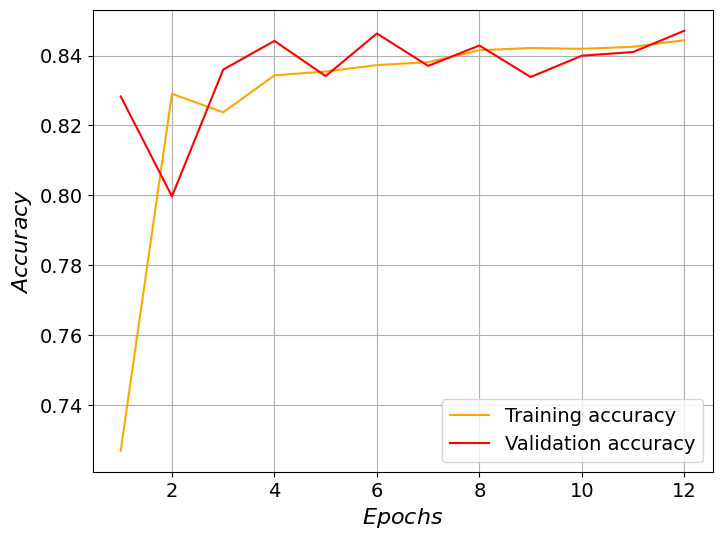

In [88]:
fn.PlotLossAcc(TrainData=AccInception, ValData=ValAccInception, Epochs=EpochsInception,
            TrainLabel='Training accuracy', ValLabel='Validation accuracy',
            yLabel=r'$Accuracy$', title=False,
            ColTrain='orange', ColVal='red', filename="../../images/acc_attention.pdf")

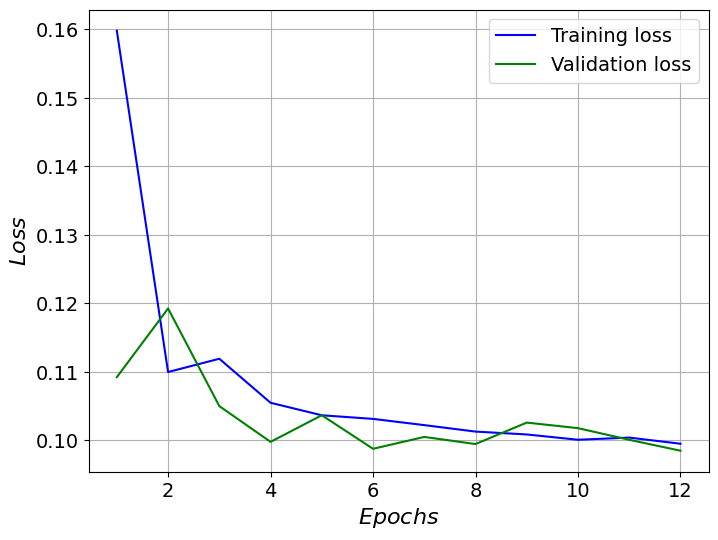

In [89]:
fn.PlotLossAcc(TrainData=LossInception, ValData=ValLossInception, Epochs=EpochsInception,
            TrainLabel='Training loss', ValLabel='Validation loss',
            yLabel=r'$Loss$', title=False,
            ColTrain='blue', ColVal='green', filename="../../images/loss_attention.pdf")

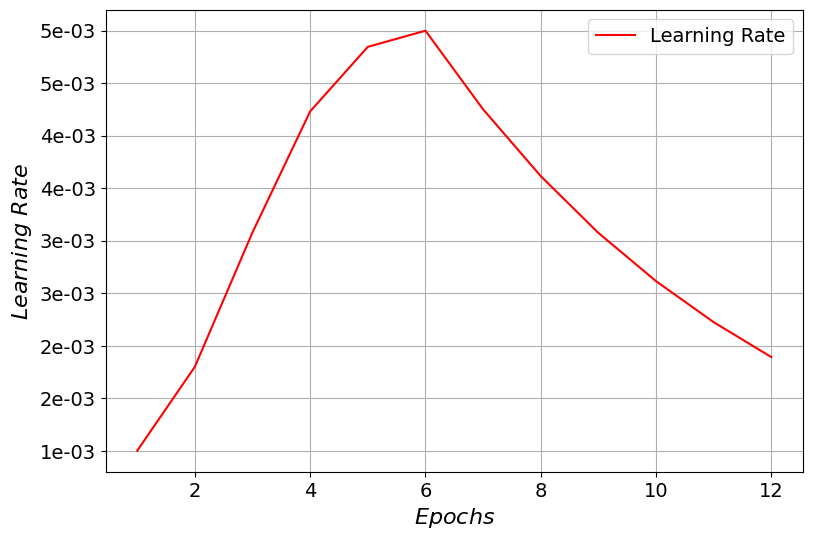

In [90]:
fn.PlotLossAcc(TrainData=LrInception, ValData=[], Epochs=EpochsInception,
            TrainLabel='', ValLabel='',
            yLabel=r'$Learning\ Rate$', title=False,
            ColTrain='red', ColVal='', filename="../../images/lr_attention.pdf", lr=True)